### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [46]:
data = pd.read_csv('training.csv')
# 過濾有缺失值的 row
data = data.dropna()

# 將圖片像素值讀取為 numpy array 的形態
data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 
imgs = np.vstack(data['Image'].values)/255
imgs = imgs.reshape(data.shape[0], 96, 96)
imgs = imgs.astype(np.float32)

In [47]:
imgs.shape

(2140, 96, 96)

In [48]:
#水平翻轉
flipped_imgs=imgs[:,:,::-1]

In [49]:
flipped_imgs = flipped_imgs.astype(np.float32)
#提取坐標的部分
points = data[data.columns[:-1]].values
# 轉換為 float
points = points.astype(np.float32)
points = points/96 - 0.5

In [57]:
flipped_points=points.copy()

In [58]:
flipped_points.shape

(2140, 30)

In [59]:
for p in flipped_points:
    for i,value in enumerate(p):
        if i%2==0:
            v=(p[i]+0.5)*96
            p[i]=(96-v)/96-0.5

In [60]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

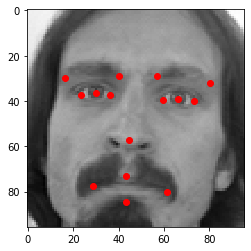

In [61]:
plot_keypoints(imgs[0],points[0])

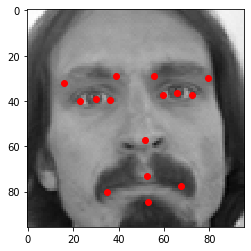

In [62]:
plot_keypoints(flipped_imgs[0],flipped_points[0])

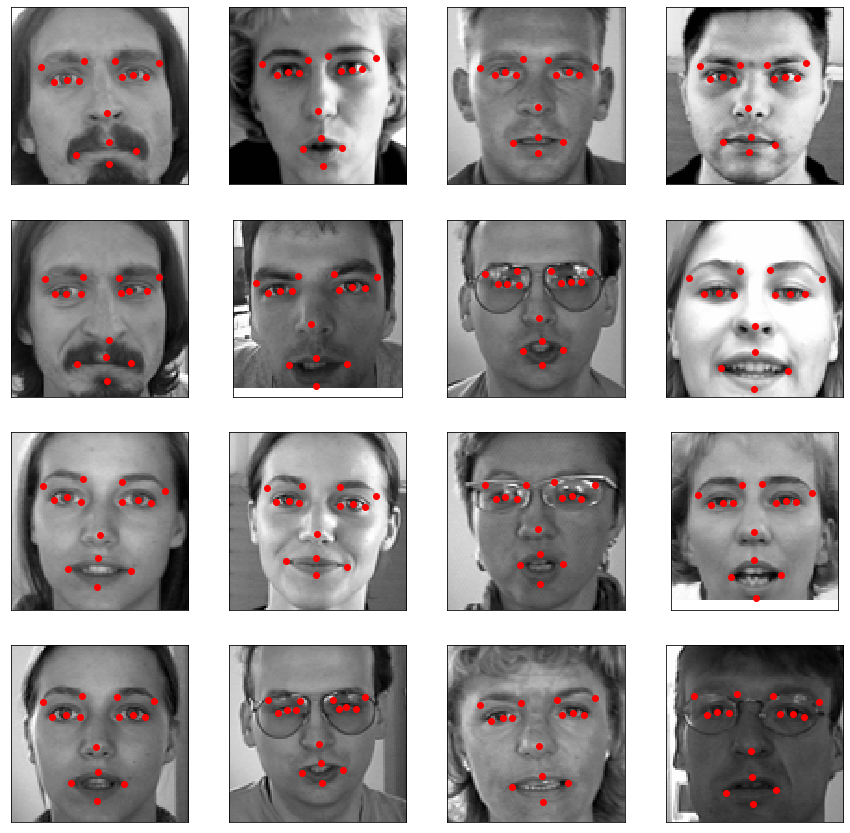

In [63]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(flipped_imgs[i], np.squeeze(flipped_points[i]))

In [64]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [65]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [66]:
from sklearn.model_selection import train_test_split
imgs_train=np.append(imgs_train,flipped_imgs,axis=0)
imgs_train=imgs_train.reshape(-1, 96, 96, 1)
points_train=np.append(points_train,flipped_points,axis=0)
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)
X_train, X_test, y_train, y_test = train_test_split(imgs_train, points_train, test_size=0.2, shuffle=True,random_state=42)

圖像資料: (4280, 96, 96, 1) 
關鍵點資料: (4280, 30)


In [67]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [68]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [69]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [70]:
# 印出網路結構
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)        

In [71]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [72]:
# training the model
hist_model = model.fit(X_train, 
                       y_train, 
                       validation_data=(X_test,y_test), batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 1s 404us/step - loss: 0.0203 - val_loss: 0.0189

Epoch 00001: val_loss improved from inf to 0.01890, saving model to best_weights.h5
Epoch 2/150
3424/3424 [==============================] - 1s 315us/step - loss: 0.0187 - val_loss: 0.0165

Epoch 00002: val_loss improved from 0.01890 to 0.01647, saving model to best_weights.h5
Epoch 3/150
3424/3424 [==============================] - 1s 312us/step - loss: 0.0156 - val_loss: 0.0119

Epoch 00003: val_loss improved from 0.01647 to 0.01193, saving model to best_weights.h5
Epoch 4/150
3424/3424 [==============================] - 1s 317us/step - loss: 0.0111 - val_loss: 0.0085

Epoch 00004: val_loss improved from 0.01193 to 0.00848, saving model to best_weights.h5
Epoch 5/150
3424/3424 [==============================] - 1s 313us/step - loss: 0.0087 - val_loss: 0.0079

Epoch 00005: val_loss improved from 0.00848 to 0.00786, saving model to bes

Epoch 50/150
3424/3424 [==============================] - 1s 317us/step - loss: 3.7867e-04 - val_loss: 0.0067

Epoch 00050: val_loss did not improve from 0.00653
Epoch 51/150
3424/3424 [==============================] - 1s 315us/step - loss: 3.6108e-04 - val_loss: 0.0068

Epoch 00051: val_loss did not improve from 0.00653
Epoch 52/150
3424/3424 [==============================] - 1s 317us/step - loss: 3.6817e-04 - val_loss: 0.0069

Epoch 00052: val_loss did not improve from 0.00653
Epoch 53/150
3424/3424 [==============================] - 1s 320us/step - loss: 3.5212e-04 - val_loss: 0.0070

Epoch 00053: val_loss did not improve from 0.00653
Epoch 54/150
3424/3424 [==============================] - 1s 322us/step - loss: 3.5887e-04 - val_loss: 0.0068

Epoch 00054: val_loss did not improve from 0.00653
Epoch 55/150
3424/3424 [==============================] - 1s 315us/step - loss: 3.6401e-04 - val_loss: 0.0072

Epoch 00055: val_loss did not improve from 0.00653
Epoch 56/150
3424/3424 [====


Epoch 00100: val_loss did not improve from 0.00653
Epoch 101/150
3424/3424 [==============================] - 1s 310us/step - loss: 2.9492e-04 - val_loss: 0.0070

Epoch 00101: val_loss did not improve from 0.00653
Epoch 102/150
3424/3424 [==============================] - 1s 313us/step - loss: 2.8302e-04 - val_loss: 0.0070

Epoch 00102: val_loss did not improve from 0.00653
Epoch 103/150
3424/3424 [==============================] - 1s 326us/step - loss: 2.8587e-04 - val_loss: 0.0070

Epoch 00103: val_loss did not improve from 0.00653
Epoch 104/150
3424/3424 [==============================] - 1s 320us/step - loss: 2.8084e-04 - val_loss: 0.0071

Epoch 00104: val_loss did not improve from 0.00653
Epoch 105/150
3424/3424 [==============================] - 1s 317us/step - loss: 2.8819e-04 - val_loss: 0.0073

Epoch 00105: val_loss did not improve from 0.00653
Epoch 106/150
3424/3424 [==============================] - 1s 316us/step - loss: 2.9011e-04 - val_loss: 0.0070

Epoch 00106: val_loss

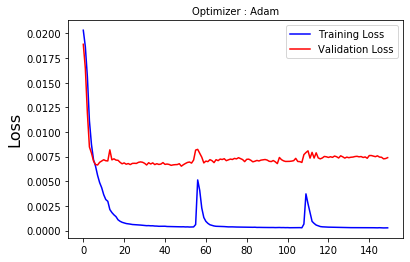

In [73]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [74]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [75]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

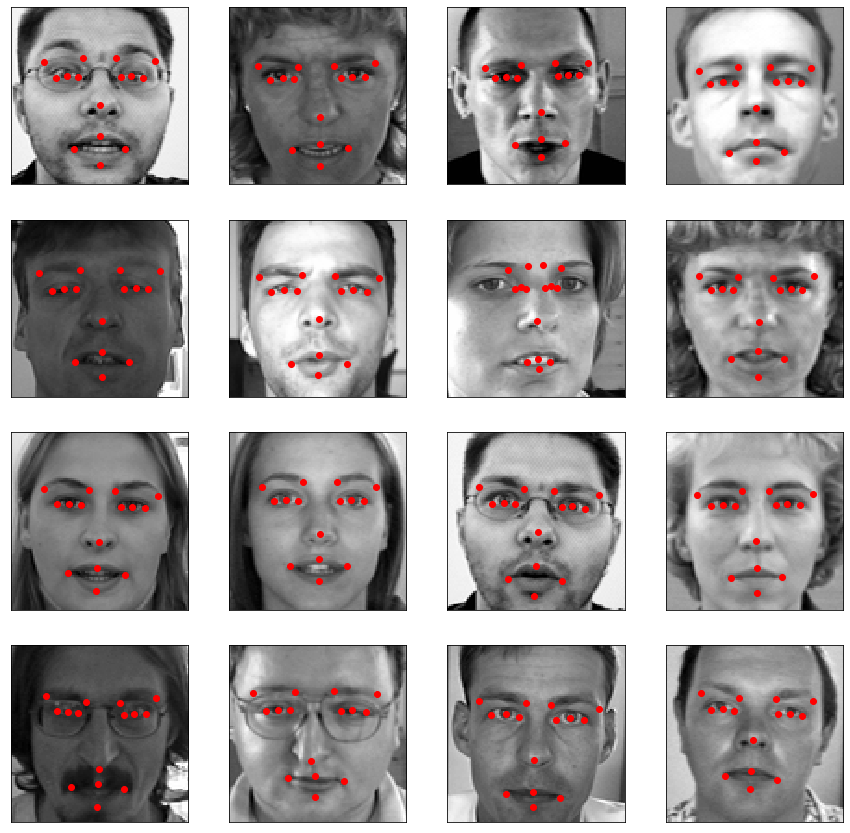

In [76]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))